In [1]:
import math
import numpy as np
import random

from agent import *
from rl import *
from utils import *

Using TensorFlow backend.
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/david/.local/lib/python3.7/site-packages/

In [2]:
class MazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goal):
        super(MazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goal = goal
        
    def onBegin(self, state, startState = None):
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
        
    def onStep(self, state):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        action = self.predict(f"s{state()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state):
        if state() == self.__goal and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state):
        return state() == self.__goal
    
    def plot(self, title):
        l, r = ([self.rl().maxValue(f"s{i}", a) for i in range(self.__size)] for a in ("left", "right"))
        plot(title, MAZE_SIZE, (l, r), ("Left", "Right"))

In [3]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

In [6]:
# Maze Settings
MAZE_SIZE = 20
GOAL      = 10

# Agent Settings
HRR_SIZE   = 512 # 64
LEARN_RATE = 0.05
EPSILON    = 0.2
DISCOUNT   = 0.95
COPY       = 50

# The agents (Q-learning, double Q-learning, deep Q-learning, double/deep Q-learning)
ql = NQLearningNetwork(1, HRR_SIZE, learnRate=LEARN_RATE, discountFactor=DISCOUNT)
agent = MazeAgent(ql, MAZE_SIZE, GOAL)

Time: 43.33 seconds
Epoch: 2000
Error: -1
Progress: [####################] 100.00%


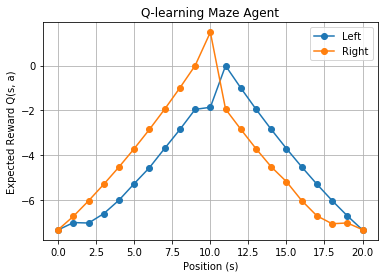

In [7]:
train("Q-learning Maze Agent", agent, maxEpochs=2000, epsilon=EPSILON, simLimit=STEP_LIMIT)